In [ ]:
from trace import Trace
import pandas as pd
import os
from executor import Executor
from conf import LisaLogging
LisaLogging.setup()
import json
from env import TestEnv
from trappy.stats.Topology import Topology
from bart.sched.SchedMultiAssert import SchedMultiAssert
from bart.sched.SchedAssert import SchedAssert
import json
from trappy.plotter import plot_trace

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
results_dir = '/home/brejac01/sources/lisa/results/20170327_153935'

In [ ]:
# platform = TestEnv.load_platform(results_dir)
platform = {
    "abi": "arm64", 
    "clusters": {
        "big": [
            0, 
            1, 
            2, 
            3
        ], 
        "little": [
            4, 
            5, 
            6, 
            7
        ]
    }, 
    "cpus_count": 8, 
    "freqs": {
        "0": [
            208000, 
            432000, 
            729000, 
            960000, 
            1200000
        ]
    }, 
    "kernel": {
        "major": 4, 
        "minor": 34, 
        "parts": [
            4, 
            4, 
            34
        ], 
        "release": "4.4.34-47027-gde8f670904a1-dirty", 
        "sha1": "de8f670904a1", 
        "version": "23 SMP PREEMPT Wed Nov 30 17:24:54 GMT 2016", 
        "version_number": 4
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 112
            }, 
            "cpu": {
                "cap_max": 1024, 
                "nrg_max": 670
            }
        }, 
        "little": {
            "cluster": {
                "nrg_max": 112
            }, 
            "cpu": {
                "cap_max": 1024, 
                "nrg_max": 670
            }
        }
    }, 
    "os": "android", 
    "topology": [
        [
            0, 
            1, 
            2, 
            3, 
            4, 
            5, 
            6, 
            7
        ]
    ]
}
# fix hikey
if platform['topology'] == [[0, 1, 2, 3, 4, 5, 6, 7]]:
    platform['topology'] = [[0, 1, 2, 3], [4, 5, 6, 7]]
topology = Topology(clusters = platform['topology'])

In [ ]:
experiments = Executor.find_experiments(results_dir)

In [ ]:
traces = [Trace(platform, e.out_dir, ['cpu_frequency', 'cpu_idle', 'sched_switch']) for e in experiments]

In [8]:
def get_freq(trace):
    freqs = trace.data_frame.trace_event('cpu_frequency')['frequency']
    [freq] = freqs.drop_duplicates().tolist()
    return freq

In [9]:
def get_packed(experiment, trace):
    if experiment.wload:
        tasks = experiment.wload.tasks.keys()
    else:
        tasks = [c for c in trace.getTasks().keys() if 'task_' in c]

    ma = SchedMultiAssert(trace.ftrace, topology, tasks)    
    
#     start = min(t['starttime'] for t in ma.getStartTime().values())
#     end = max(t['endtime'] for t in ma.getEndTime().values())
#     print end - start
    cluster_conclusions = []
    for cluster in topology.get_level('cluster'):
        residencies = [t['residency'] for p, t in ma.getResidency('cluster', cluster, percent=True).iteritems()]
        if all(r > 90 for r in residencies):
            cluster_conclusions.append('PACKED')
        else:
            cluster_conclusions.append(None)
    clusters_packed = [i for i, c in enumerate(cluster_conclusions) if c == 'PACKED']
    
    if not clusters_packed:
        # print "I don't think we packed onto any cluster"
        return 'Packed'
        # plot_trace(trace.ftrace)
    elif len(clusters_packed) == 1:
        [i] = clusters_packed
        # print 'I think we packed onto cluster {} ({})'.format(i, te.topology.get_node('cluster', i))
        return 'Unpacked'
    else:
        raise Exception('this code is borken')

In [31]:
def get_energy(experiment):
    with open(os.path.join(experiment.out_dir, 'samples.csv')) as f:
        df = pd.DataFrame.from_csv(f)
        samples_energy = df['BAT_power'].sum()
    with open(os.path.join(experiment.out_dir, 'energy.json')) as f:
        json_energy = sum(json.load(f).values())
    print samples_energy - json_energy
    return samples_energy

In [32]:
results = []
for experiment, trace in zip(experiments, traces):
    freq = get_freq(trace)
    packed = get_packed(experiment, trace)
    energy = get_energy(experiment)
    results.append((freq, packed, energy))

350.992910557
356.289112475
349.672010645
344.130239036
349.410925488
336.114082077
334.469280052
337.113046637
334.86338629
339.709838426
329.363041128
317.931228283
323.164640527
325.968390592
327.672227769
334.245582717
329.460878502
334.651288938
333.131346389
329.404803317
375.92823362
384.916305013
374.307330387
379.225876803
379.138978824
339.76074543
338.733006227
340.778678844
342.934737001
338.469090899
335.15924134
330.787963656
331.242662268
330.709736356
327.901056921
323.936556452
321.802753238
323.408460818
319.877935589
318.220066827
347.362239468
348.413942005
352.739684934
344.474445017
350.842916114
374.177526691
384.924376588
377.052248867
376.210103773
376.724050187


In [17]:
found_freqs = set()
for trace in traces[:0]:
    freq = get_freq(trace)
    if freq in found_freqs:
        continue
    found_freqs.add(freq)
    print freq
    plot_trace(trace.ftrace)

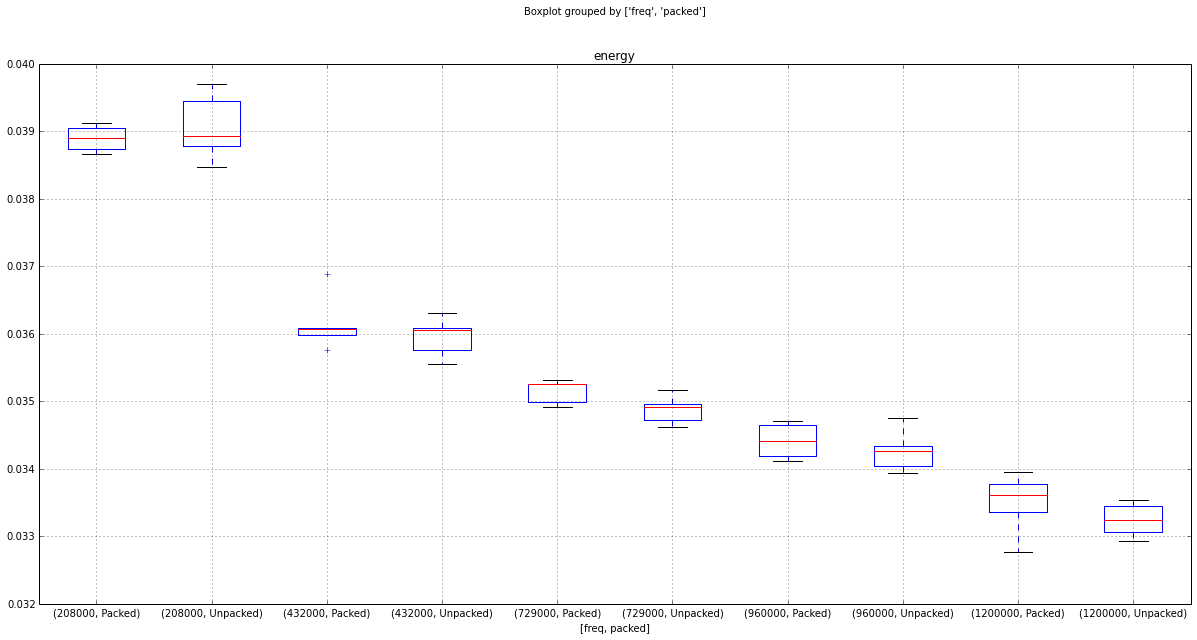

In [18]:
df = pd.DataFrame(results, columns=['freq', 'packed', 'energy'])
df = df
df.boxplot(by=['freq', 'packed'], figsize=(20, 10))

In [47]:
def f(i):
    plot_trace(traces[i].ftrace)
    print get_freq(traces[i])
f(10)

1200000


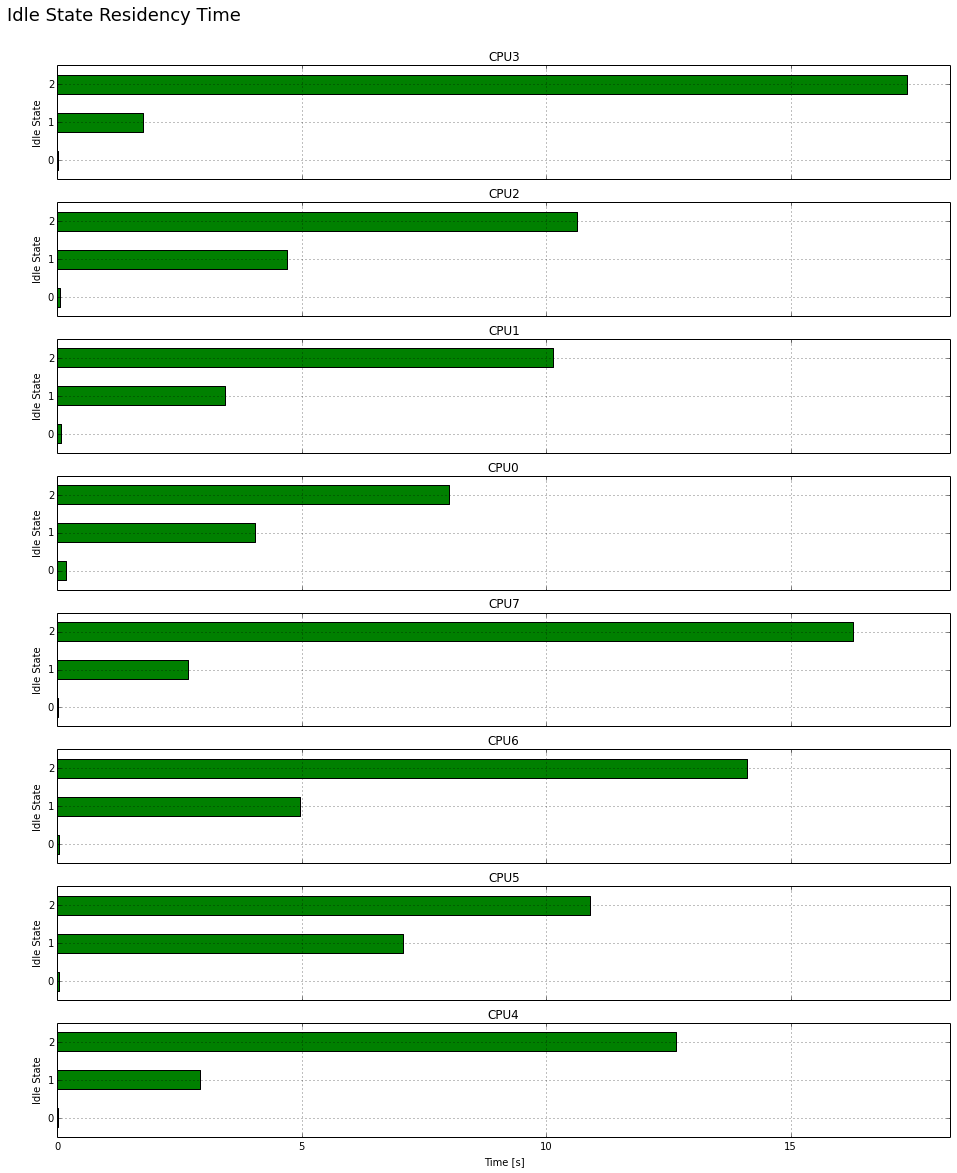

In [37]:
trace.analysis.idle.plotCPUIdleStateResidency()